In [109]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.metrics import (evaluate_multistep,
                                             calculate_rms, calculate_bias, 
                                             calculate_bias_flv, calculate_bias_fhv,
                                             calculate_bias, calculate_nse, calculate_kge,
                                            )
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [110]:
def dt(dates, format="%d/%m/%Y %H:%M"):
    if dates.tz == None:
        # make TZ aware
        return pd.to_datetime(dates, format=format).tz_localize("Europe/London").tz_convert("UTC")
    else:
        return pd.to_datetime(dates, format=format).tz_convert("UTC")
   

In [111]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [112]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "black",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
              r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
              ls = "-",
              )
     }

arima
computing statistics
computing statistics
elstm
dictonary loaded
35/35 [==============================] - 1s 10ms/step
computing statistics
computing statistics
pbhm-hlstm
dictonary loaded
35/35 [==============================] - 1s 10ms/step
computing statistics
computing statistics


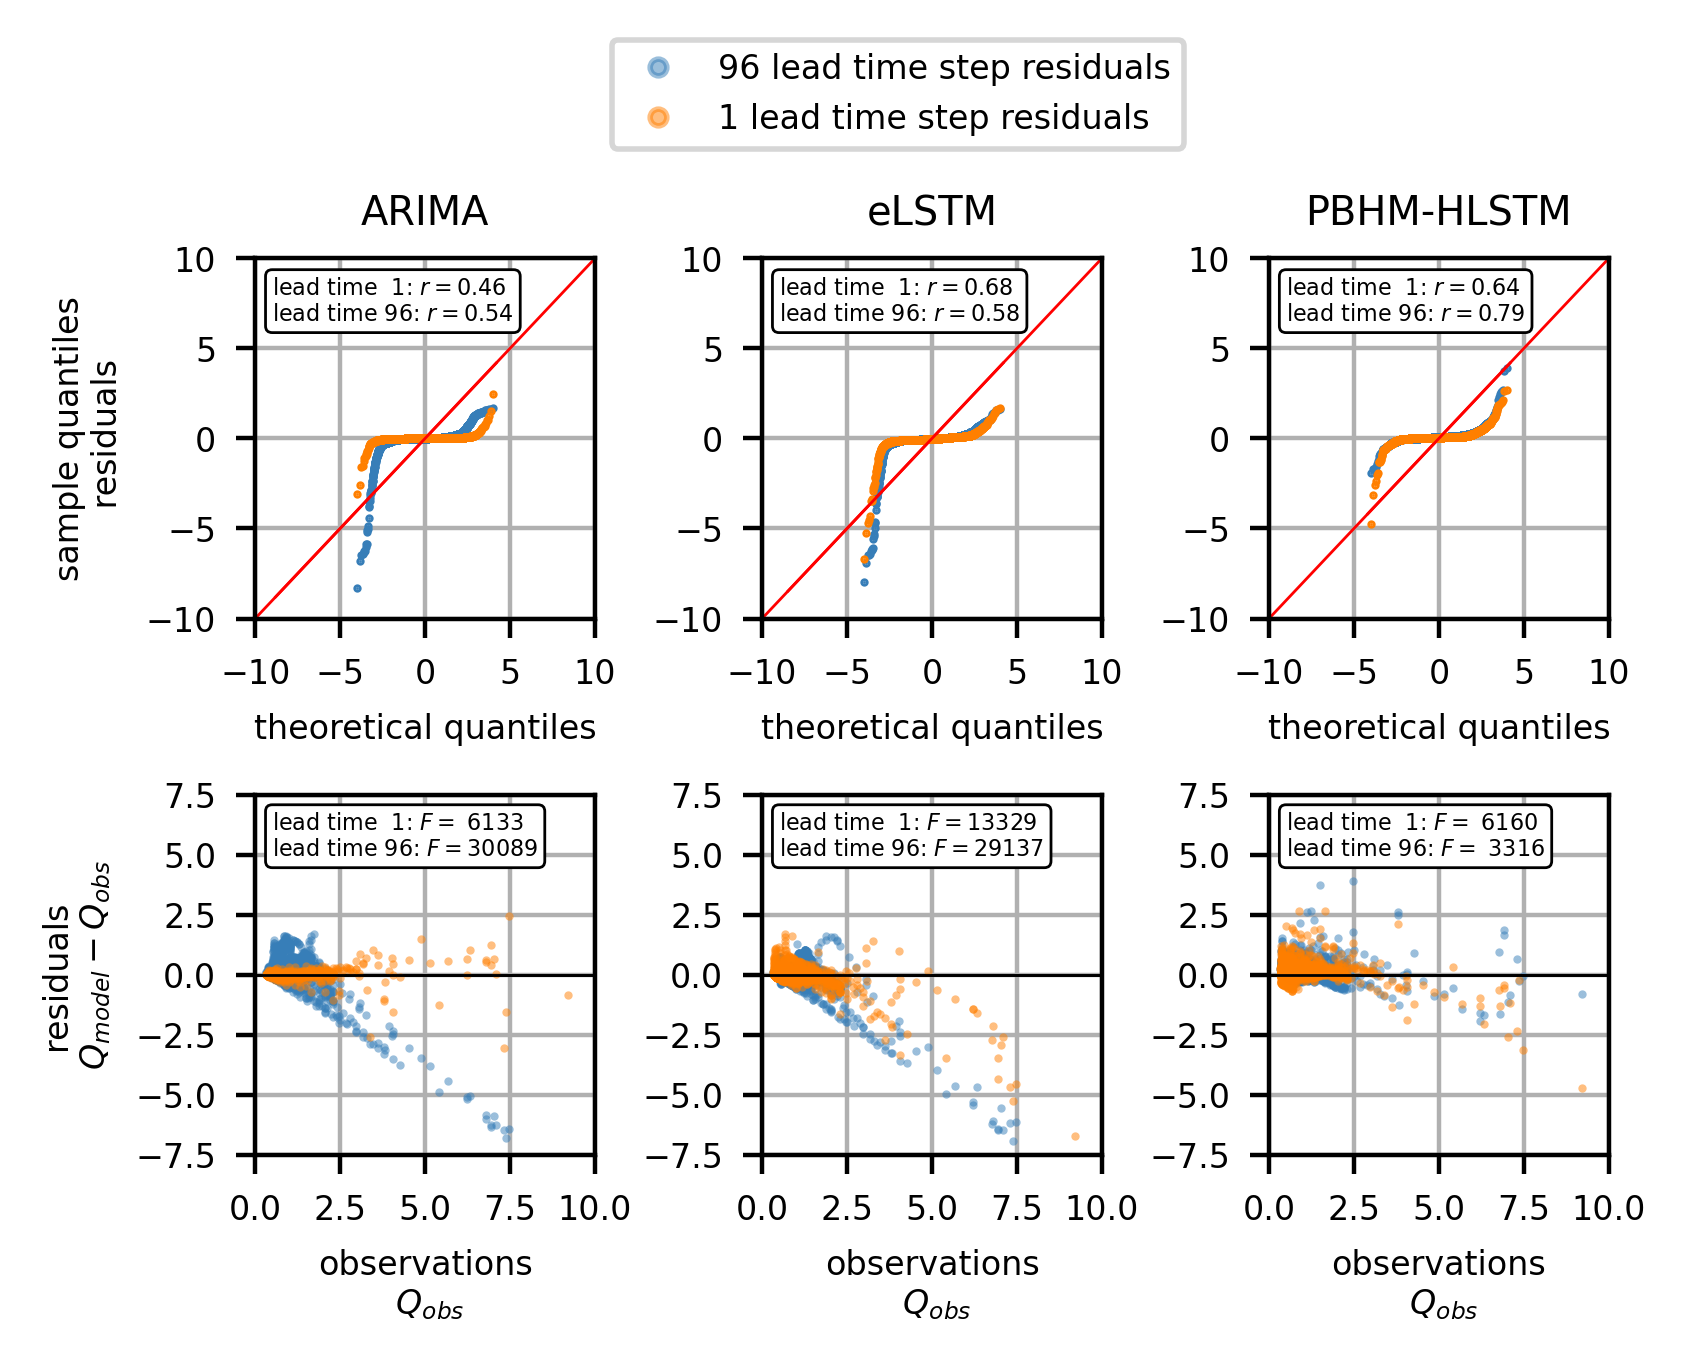

In [141]:
# define metrics to evaluate
eval_metrics = {
        "fhv" : calculate_bias_fhv,
        "flv" : calculate_bias_flv,
        "bias" : calculate_bias,
        "nse" : calculate_nse,
        "kge" : calculate_kge,
    }

#colors = ["red", "blue", "green", "magenta", "gray", "black"]
colors = {95: '#377eb8', 0:'#ff7f00'} 
fig, axes = plt.subplots(2,3,figsize=(4.72,3), dpi=400)
df = pd.DataFrame(columns = ["filliben", "het_lm", "het_fstat"], 
                     index=pd.MultiIndex(levels=[[],np.arange(96)], 
                                  codes=[[],[]], 
                                  names=["model", "leadtime"],
                                 ),
                    )
idx = -10
for n, key in enumerate(models.keys()):
    idx += 10
    print(key)
    
    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    res = np.array([])
    yp_all = np.array([])
    #for n_fold in range(5):
    n_fold = 4
    year = 2013 + n_fold
    if models[key].is_external_model:
        # load external which come already with observations
        ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

        # get external model observations
        y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

        # get external model predictions
        yp = ext_df.filter(like="fc").values
                    
    else:
        # load dataset
        X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

        #if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
         #   yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
      #  else:
            # load model
        tf.keras.backend.clear_session()
        model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

        # model prediction
        yp = model.predict(X, batch_size=1000)

    # calculate residuals
    res = yp - y[:,:,0]

    # plot first and last lead time step
    for lts in [95, 0]:     
        print("computing statistics")
        rst_gof  = stats.goodness_of_fit(stats.norm, 
                                         res[:,lts], 
                                         statistic="filliben", 
                                         n_mc_samples=100, # speed up for testing
                                        )
        filliben = rst_gof.statistic

        exog      = np.append(np.ones_like(y[:,lts]), y[:,lts], axis=1)
        rst_het   = het_breuschpagan(res[:,lts], exog)
        het_lm    = rst_het[0]
        het_fstat = rst_het[2]
        df.loc[(key, lts), :] = [filliben, het_lm, het_fstat]
    #
        # plotting
        sm.qqplot(res[:,lts], ax=axes[0,n], markersize=0.5, markerfacecolor=colors[lts], markeredgecolor=colors[lts])
        sm.qqline(ax=axes[0,n], line='45', fmt='r--', linewidth=0.5)

        axes[0,n].set_title(models[key].name)
        axes[0,n].grid(True)
        axes[0,n].set_xticks(np.arange(-10,11,5))
        axes[0,n].set_xlim((-10,10))
        axes[0,n].set_ylim((-10,10))
        axes[0,n].set_xlabel("theoretical quantiles")
        if n == 0:
            axes[0,n].set_ylabel("sample quantiles\n residuals")
        else:
            axes[0,n].set_ylabel("")
            
    
        axes[1,n].plot(y[:,lts,0], res[:,lts], marker=".", ls="None",
                       markersize=1, alpha=0.5, color=colors[lts],
                       label=f"{lts+1} lead time step residuals",
                      )
        axes[1,n].grid(True)
        axes[1,n].axhline(0, color="k", lw=0.5)
        axes[1,n].set_xticks(np.arange(0,11,2.5))
        axes[1,n].set_yticks(np.arange(-7.5,7.6,2.5))
        axes[1,n].set_xlim((0,10))
        axes[1,n].set_ylim((-7.5,7.5))
        axes[1,n].set_xlabel("observations\n $Q_{obs}$")
        if n == 0:
            axes[1,n].set_ylabel("residuals\n  $Q_{model}-Q_{obs}$")

    txt_fstat = []
    txt_r = []
    for lts in [0, 95]:
        txt_fstat.append(f"lead time {lts+1:>2d}: "+"$F = $" + f"{int(df.loc[(key,lts), 'het_fstat']):>5d}")
        txt_r .append(   f"lead time {lts+1:>2d}: "+"$r = $" + f"{df.loc[(key,lts), 'filliben']:4.2f}")

    txt_fstat = "\n".join(txt_fstat)
    txt_r     = "\n".join(txt_r)
        
    axes[0,n].text(-9, 9,  txt_r, 
                   va="top", ha="left", fontsize=4,
                   bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     },
                  )
    axes[1,n].text(0.5, 6.8, txt_fstat, 
                   va="top", ha="left", fontsize=4,
                   bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     },
                   )
    
fig.tight_layout()
plt.subplots_adjust(right=0.85)
lgd = axes[1,1].legend(bbox_to_anchor=(0.4, 2.7),
                  loc='lower center', ncol=1, 
                  borderaxespad=1)

for h in lgd.legend_handles:
    h.set_markersize(6)

In [137]:
fig.savefig(os.path.join(PLOT_PATH, 'figX_residuals.png'), dpi=300, bbox_inches='tight')

(0.5, 1.5)

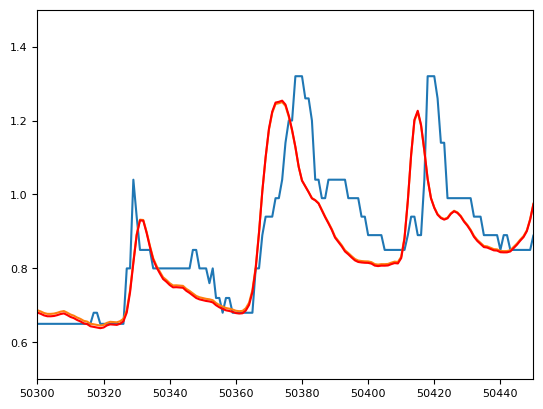

In [15]:
step = 95
plt.plot(y[:,step,0])
plt.plot(yp[:,step])
plt.plot(yp[:,step] + rst.intercept + rst.slope*yp[:,step], color="r")
plt.xlim((50300, 50450))
plt.ylim((0.5, 1.5))

In [16]:
plt.gcf().savefig(os.path.join(PLOT_PATH, 'residuals-ymeas.png'), dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>